In [ ]:
import os
import sys
from starter import Starter

starter = Starter()
starter.start(lambda: os.chdir(os.path.join(os.getcwd(), '..')))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import json
import time
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from utils.data_loader import DataLoader
from utils.metrics_calculator import MetricsCalculator
from models.rnn import RNNModelBuilder
from playgrounds.starter import Starter

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

print("="*60)
print("RNN Implementation - Tugas Besar 2 IF3270")
print("Convolutional Neural Network dan Recurrent Neural Network")
print("="*60)
print("✅ Setup completed successfully!")
print("✅ All imports loaded!")
print("✅ Random seeds set for reproducibility!")

Starter has already been initialized.


2025-05-30 12:55:36.190911: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 12:55:37.994098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 12:55:39.526721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748584541.050632   30507 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748584541.369643   30507 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748584545.038635   30507 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
#!/usr/bin/env python3
"""
Cell 02: Data Loading and Preprocessing
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("1. LOADING AND PREPROCESSING DATA")
print("="*50)

# Initialize data loader
data_dir = "../data"  # Adjust path as needed
data_loader = DataLoader(data_dir)

# Load and prepare data
try:
    X_train, y_train, X_valid, y_valid, X_test, y_test = data_loader.prepare_data(
        max_vocab_size=5000,
        max_length=50,
    )
    
    print(f"\n✅ Data loaded successfully!")
    print(f"📊 Vocabulary size: {data_loader.preprocessor.vocab_size}")
    print(f"📊 Number of classes: {data_loader.num_classes}")
    print(f"📊 Max sequence length: {data_loader.preprocessor.max_length}")
    
    # Show class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\n📈 Class distribution in training data:")
    for class_id, count in zip(unique, counts):
        class_name = data_loader.reverse_label_encoder[class_id]
        print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
        
    print(f"\n📏 Data shapes:")
    print(f"  Training: X={X_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={X_valid.shape}, y={y_valid.shape}")
    print(f"  Test: X={X_test.shape}, y={y_test.shape}")
    
    # Display sample data
    print(f"\n🔍 Sample data:")
    print(f"  First training text tokens: {X_train[0][:10]}...")
    print(f"  First training label: {y_train[0]} ({data_loader.reverse_label_encoder[y_train[0]]})")
    
    # Verify data integrity
    print(f"\n✅ Data integrity checks:")
    print(f"  No missing values in X_train: {not np.any(np.isnan(X_train))}")
    print(f"  No missing values in y_train: {not np.any(np.isnan(y_train))}")
    print(f"  All labels in valid range: {np.all((y_train >= 0) & (y_train < data_loader.num_classes))}")
    
    print(f"\n✅ Data preprocessing completed successfully!")
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    import traceback
    traceback.print_exc()
    raise e

1. LOADING AND PREPROCESSING DATA
Loaded data:
  Train: 500 samples
  Valid: 100 samples
  Test: 400 samples
Keras vectorizer vocabulary size: 2836
Sample vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini')]

Data shapes:
  X_train: (500, 50)
  y_train: (500,)
  X_valid: (100, 50)
  y_valid: (100,)
  X_test: (400, 50)
  y_test: (400,)

✅ Data loaded successfully!
📊 Vocabulary size: 2836
📊 Number of classes: 3
📊 Max sequence length: 50

📈 Class distribution in training data:
  negative: 192 (38.4%)
  neutral: 119 (23.8%)
  positive: 189 (37.8%)

📏 Data shapes:
  Training: X=(500, 50), y=(500,)
  Validation: X=(100, 50), y=(100,)
  Test: X=(400, 50), y=(400,)

🔍 Sample data:
  First training text tokens: [1758 1080 1145  196 2834  198   11  607  177  847]...
  First training label: 1 (neutral)

✅ Data integrity checks:
  No missing values in X_train: True
  No missing values in y_t

2025-05-30 03:15:37.686817: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
#!/usr/bin/env python3
"""
Cell 03: Keras RNN Experiment Framework
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

class KerasRNNExperiment:
    """Keras RNN experiment class for systematic hyperparameter analysis"""
    
    def __init__(self, data_loader, X_train, y_train, X_valid, y_valid, X_test, y_test):
        self.data_loader = data_loader
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
        # Base configuration
        self.base_config = {
            'vocab_size': data_loader.preprocessor.vocab_size,
            'embedding_dim': 64,
            'rnn_units': 32,
            'num_classes': data_loader.num_classes,
            'max_length': data_loader.preprocessor.max_length,
            'activation': 'tanh',
            'dropout_rate': 0.2,
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 15  # Increased for better training
        }
        
        print(f"🏗️ Base configuration:")
        for key, value in self.base_config.items():
            print(f"  {key}: {value}")
    
    def create_keras_model(self, config):
        """Create Keras RNN model with given configuration"""
        model = Sequential()
        
        # Embedding layer
        model.add(Embedding(
            input_dim=config['vocab_size'],
            output_dim=config['embedding_dim'],
            input_length=config['max_length'],
            name='embedding'
        ))
        
        # RNN layers
        for i in range(config['num_rnn_layers']):
            return_sequences = i < config['num_rnn_layers'] - 1
            
            rnn_layer = SimpleRNN(
                config['rnn_units'],
                activation=config['activation'],
                return_sequences=return_sequences,
                name=f'simple_rnn_{i}'
            )
            
            if config['bidirectional']:
                model.add(Bidirectional(rnn_layer, name=f'bidirectional_rnn_{i}'))
            else:
                model.add(rnn_layer)
            
            # Add dropout after each RNN layer except the last
            if i < config['num_rnn_layers'] - 1:
                model.add(Dropout(config['dropout_rate'], name=f'dropout_{i}'))
        
        # Final dropout and classification layer
        model.add(Dropout(config['dropout_rate'], name='dropout_final'))
        model.add(Dense(config['num_classes'], activation='softmax', name='classification'))
        
        # Build model with proper input shape
        model.build(input_shape=(None, config['max_length']))
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=config['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_and_evaluate(self, config, experiment_name):
        """Train and evaluate a single configuration - FIXED VERSION"""
        print(f"\n{'='*60}")
        print(f"🚀 Training: {experiment_name}")
        print(f"⚙️ Config: {config}")
        print(f"{'='*60}")
        
        start_time = time.time()
        
        # Create model
        model = self.create_keras_model(config)
        print(f"📊 Model created with {model.count_params():,} parameters")
        
        # Train model with validation monitoring
        print(f"🏃 Starting training for {config['epochs']} epochs...")
        history = model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_valid, self.y_valid),
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                )
            ]
        )
        
        # Evaluate on test set
        print(f"📝 Evaluating on test set...")
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=0)
        test_predictions = model.predict(self.X_test, verbose=0)
        test_pred_classes = np.argmax(test_predictions, axis=1)
        
        # Calculate macro F1-score
        test_f1_macro = f1_score(self.y_test, test_pred_classes, average='macro')
        
        # Also evaluate on validation set for consistency
        valid_predictions = model.predict(self.X_valid, verbose=0)
        valid_pred_classes = np.argmax(valid_predictions, axis=1)
        valid_f1_macro = f1_score(self.y_valid, valid_pred_classes, average='macro')
        
        # Save weights for from-scratch comparison
        weights_path = f"results/{experiment_name}_weights.npz"
        os.makedirs("results", exist_ok=True)
        self.save_keras_weights(model, weights_path, config)
        
        training_time = time.time() - start_time
        
        print(f"\n📊 Results for {experiment_name}:")
        print(f"  ⏱️ Training time: {training_time:.2f} seconds")
        print(f"  🎯 Test Accuracy: {test_acc:.4f}")
        print(f"  🎯 Test F1-Score (macro): {test_f1_macro:.4f}")
        print(f"  🎯 Valid F1-Score (macro): {valid_f1_macro:.4f}")
        print(f"  💾 Weights saved to: {weights_path}")
        
        return {
            'model': model,
            'history': history.history,
            'test_accuracy': test_acc,
            'test_f1_score': test_f1_macro,
            'valid_f1_score': valid_f1_macro,
            'weights_path': weights_path,
            'config': config,
            'training_time': training_time
        }
    
    def save_keras_weights(self, model, filepath, config):
        """Save Keras weights in format compatible with from-scratch model - FIXED VERSION"""
        print(f"💾 Saving Keras weights to: {filepath}")
        
        try:
            # Verify model has weights
            if len(model.weights) == 0:
                raise ValueError("Model has no weights to save!")
            
            weights_dict = {}
            rnn_layer_count = 0
            
            for layer in model.layers:
                layer_weights = layer.get_weights()
                if len(layer_weights) == 0:
                    continue
                    
                layer_name = layer.name
                print(f"  Processing layer: {layer_name} - {len(layer_weights)} weight arrays")
                
                if 'embedding' in layer_name.lower():
                    weights_dict['embedding'] = {
                        'embedding_matrix': layer_weights[0]
                    }
                elif 'simple_rnn' in layer_name.lower():
                    target_name = f'rnn_{rnn_layer_count}'
                    weights_dict[target_name] = {
                        'W_ih': layer_weights[0].T,  # Transpose for our convention
                        'W_hh': layer_weights[1].T,  # Transpose for our convention
                        'b_h': layer_weights[2]
                    }
                    rnn_layer_count += 1
                elif 'bidirectional' in layer_name.lower():
                    target_name = f'bidirectional_rnn_{rnn_layer_count}'
                    if len(layer_weights) >= 6:
                        weights_dict[target_name] = {
                            'forward_W_ih': layer_weights[0].T,
                            'forward_W_hh': layer_weights[1].T,
                            'forward_b_h': layer_weights[2],
                            'backward_W_ih': layer_weights[3].T,
                            'backward_W_hh': layer_weights[4].T,
                            'backward_b_h': layer_weights[5]
                        }
                    rnn_layer_count += 1
                elif 'dense' in layer_name.lower() or 'classification' in layer_name.lower():
                    weights_dict['classification'] = {
                        'W': layer_weights[0].T,  # Transpose for our convention
                        'b': layer_weights[1]
                    }
            
            # Save weights
            save_dict = {}
            for layer_name, layer_weights in weights_dict.items():
                for weight_name, weight_value in layer_weights.items():
                    save_dict[f"{layer_name}_{weight_name}"] = weight_value
            
            # Also save configuration for reference
            save_dict['config'] = json.dumps(config)
            
            np.savez(filepath, **save_dict)
            print(f"  ✅ Saved {len(save_dict)-1} weight arrays successfully")
            print(f"  📝 Layers saved: {list(weights_dict.keys())}")
            
            # Verify save
            loaded_check = np.load(filepath)
            assert len(loaded_check.files) == len(save_dict), "Save verification failed"
            loaded_check.close()
            
        except Exception as e:
            print(f"❌ Error saving weights: {e}")
            import traceback
            traceback.print_exc()
            raise

# Initialize experiment runner
print("🏗️ Initializing Keras experiment framework...")
keras_experiment = KerasRNNExperiment(
    data_loader, X_train, y_train, X_valid, y_valid, X_test, y_test
)
print("✅ Keras experiment runner initialized!")

🏗️ Initializing Keras experiment framework...
🏗️ Base configuration:
  vocab_size: 2836
  embedding_dim: 64
  rnn_units: 32
  num_classes: 3
  max_length: 50
  activation: tanh
  dropout_rate: 0.2
  learning_rate: 0.001
  batch_size: 32
  epochs: 15
✅ Keras experiment runner initialized!


In [ ]:
#!/usr/bin/env python3
"""
Cell 04: RNN Layer Count Analysis
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("2. HYPERPARAMETER ANALYSIS")
print("="*50)

print("\n2.1 Analyzing Effect of RNN Layer Count")
print("-"*40)
print("📊 Testing 3 different numbers of RNN layers as required by specification")

# Test 3 different numbers of RNN layers as required
layer_counts = [1, 2, 3]
layer_results = {}

for num_layers in layer_counts:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_rnn_layers': num_layers,
        'bidirectional': True,  # Start with unidirectional for fair comparison
        'rnn_units': 64  # Use consistent units
    })
    
    experiment_name = f"rnn_layers_{num_layers}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Layers: {num_layers}, Units: {config['rnn_units']}, Bidirectional: {config['bidirectional']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        layer_results[num_layers] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN LAYER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(layer_results.keys()):
    result = layer_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if layer_results:
    best_layers = max(layer_results.keys(), key=lambda x: layer_results[x]['test_f1_score'])
    print(f"\n🏆 Best layer count: {best_layers} layers")
    print(f"   F1-Score: {layer_results[best_layers]['test_f1_score']:.4f}")
    print(f"   Accuracy: {layer_results[best_layers]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [layer_results[layers]['test_f1_score'] for layers in sorted(layer_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "📈 Performance increases with more layers"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "📉 Performance decreases with more layers (possible overfitting)"
        else:
            trend = "📊 Performance remains stable across layer counts"
        print(f"   Trend: {trend}")
else:
    print("❌ No successful layer experiments completed")
    best_layers = 1  # Default fallback

2. HYPERPARAMETER ANALYSIS

2.1 Analyzing Effect of RNN Layer Count
----------------------------------------
📊 Testing 3 different numbers of RNN layers as required by specification

🔬 Experiment: rnn_layers_1
   Layers: 1, Units: 64, Bidirectional: False

🚀 Training: rnn_layers_1
⚙️ Config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': False}
📊 Model created with 189,955 parameters
🏃 Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3991 - loss: 1.0714 - val_accuracy: 0.5100 - val_loss: 1.0086
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5456 - loss: 0.8962 - val_accuracy: 0.4500 - val_loss: 1.0541
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7868 - loss: 0.6276 - val_accuracy: 0.4900 - val_loss: 1.0611
Epoch 4/15
1

In [ ]:
#!/usr/bin/env python3
"""
Cell 05: RNN Units Analysis
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("\n2.2 Analyzing Effect of RNN Units per Layer")
print("-"*40)
print("📊 Testing 3 different numbers of RNN units as required by specification")

# Test 3 different numbers of RNN units as required
unit_counts = [32, 64, 128]
unit_results = {}

for num_units in unit_counts:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_rnn_layers': 1,  # Use single layer for fair comparison
        'rnn_units': num_units,
        'bidirectional': False
    })
    
    experiment_name = f"rnn_units_{num_units}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Layers: {config['num_rnn_layers']}, Units: {num_units}, Bidirectional: {config['bidirectional']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        unit_results[num_units] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN UNITS PER LAYER:")
print(f"{'Units':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10} {'Params':<10}")
print("-"*50)
for units in sorted(unit_results.keys()):
    result = unit_results[units]
    params = result['model'].count_params()
    print(f"{units:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}      {params:,}")

# Find best configuration
if unit_results:
    best_units = max(unit_results.keys(), key=lambda x: unit_results[x]['test_f1_score'])
    print(f"\n🏆 Best unit count: {best_units} units")
    print(f"   F1-Score: {unit_results[best_units]['test_f1_score']:.4f}")
    print(f"   Accuracy: {unit_results[best_units]['test_accuracy']:.4f}")
    print(f"   Parameters: {unit_results[best_units]['model'].count_params():,}")
    
    # Analyze relationship between units and performance
    units_list = sorted(unit_results.keys())
    f1_list = [unit_results[u]['test_f1_score'] for u in units_list]
    
    print(f"\n📈 Performance vs Complexity Analysis:")
    for i, units in enumerate(units_list):
        result = unit_results[units]
        params = result['model'].count_params()
        efficiency = result['test_f1_score'] / (params / 1000)  # F1 per 1K parameters
        print(f"   {units} units: F1={result['test_f1_score']:.4f}, Params={params:,}, Efficiency={efficiency:.6f}")
    
    # Analyze trend
    if len(f1_list) >= 2:
        if f1_list[-1] > f1_list[0]:
            trend = "📈 Performance increases with more units"
        elif f1_list[-1] < f1_list[0]:
            trend = "📉 Performance decreases with more units (possible overfitting)"
        else:
            trend = "📊 Performance plateaus with more units"
        print(f"   Trend: {trend}")
        
        # Check for diminishing returns
        if len(f1_list) == 3:
            improvement_1to2 = f1_list[1] - f1_list[0]
            improvement_2to3 = f1_list[2] - f1_list[1]
            if improvement_2to3 < improvement_1to2 * 0.5:
                print(f"   💡 Diminishing returns observed: {improvement_1to2:.4f} → {improvement_2to3:.4f}")
else:
    print("❌ No successful units experiments completed")
    best_units = 64  # Default fallback


2.2 Analyzing Effect of RNN Units per Layer
----------------------------------------
📊 Testing 3 different numbers of RNN units as required by specification

🔬 Experiment: rnn_units_32
   Layers: 1, Units: 32, Bidirectional: False

🚀 Training: rnn_units_32
⚙️ Config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 32, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': False}
📊 Model created with 184,707 parameters
🏃 Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3867 - loss: 1.0918 - val_accuracy: 0.4900 - val_loss: 1.0436
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6780 - loss: 0.9203 - val_accuracy: 0.4900 - val_loss: 1.0273
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7971 - loss: 0.6314 - val_accuracy: 0.5500 - val_loss: 0.9559
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━

In [ ]:
#!/usr/bin/env python3
"""
Cell 06: Bidirectional vs Unidirectional Analysis
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("\n2.3 Analyzing Effect of Bidirectional RNN")
print("-"*40)
print("📊 Testing 2 variations: bidirectional vs unidirectional as required by specification")

# Test bidirectional vs unidirectional as required
direction_results = {}

for is_bidirectional in [False, True]:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_rnn_layers': 1,
        'rnn_units': 64,  # Use best performing unit count from previous analysis
        'bidirectional': is_bidirectional
    })
    
    direction_name = "bidirectional" if is_bidirectional else "unidirectional"
    experiment_name = f"rnn_{direction_name}"
    
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Layers: {config['num_rnn_layers']}, Units: {config['rnn_units']}, Bidirectional: {is_bidirectional}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        direction_results[direction_name] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN DIRECTION:")
print(f"{'Direction':<15} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10} {'Params':<10}")
print("-"*60)
for direction in ['unidirectional', 'bidirectional']:
    if direction in direction_results:
        result = direction_results[direction]
        params = result['model'].count_params()
        print(f"{direction:<15} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}      {params:,}")

# Detailed analysis
if len(direction_results) == 2:
    uni_f1 = direction_results['unidirectional']['test_f1_score']
    bi_f1 = direction_results['bidirectional']['test_f1_score']
    uni_params = direction_results['unidirectional']['model'].count_params()
    bi_params = direction_results['bidirectional']['model'].count_params()
    uni_time = direction_results['unidirectional']['training_time']
    bi_time = direction_results['bidirectional']['training_time']
    
    print(f"\n📈 Detailed Comparison:")
    print(f"{'Metric':<20} {'Unidirectional':<15} {'Bidirectional':<15} {'Difference':<15}")
    print("-"*65)
    print(f"{'F1-Score':<20} {uni_f1:<15.4f} {bi_f1:<15.4f} {(bi_f1-uni_f1):<15.4f}")
    print(f"{'Parameters':<20} {uni_params:<15,} {bi_params:<15,} {(bi_params-uni_params):<15,}")
    print(f"{'Training Time':<20} {uni_time:<15.1f} {bi_time:<15.1f} {(bi_time-uni_time):<15.1f}")
    
    # Performance analysis
    if bi_f1 > uni_f1:
        improvement = ((bi_f1 - uni_f1) / uni_f1) * 100
        param_increase = ((bi_params - uni_params) / uni_params) * 100
        time_increase = ((bi_time - uni_time) / uni_time) * 100
        
        print(f"\n🏆 Bidirectional RNN wins:")
        print(f"   📈 Performance improvement: {improvement:.2f}%")
        print(f"   💾 Parameter increase: {param_increase:.1f}%")
        print(f"   ⏱️ Training time increase: {time_increase:.1f}%")
        print(f"   💡 Efficiency (perf/param): {improvement/param_increase:.3f}")
        
        best_direction = "bidirectional"
        direction_conclusion = f"Bidirectional RNN performs {improvement:.1f}% better than unidirectional"
    else:
        improvement = ((uni_f1 - bi_f1) / bi_f1) * 100
        print(f"\n🏆 Unidirectional RNN wins:")
        print(f"   📈 Performance advantage: {improvement:.2f}%")
        print(f"   💾 Uses {((uni_params/bi_params-1)*-100):.1f}% fewer parameters")
        print(f"   ⏱️ Trains {((uni_time/bi_time-1)*-100):.1f}% faster")
        
        best_direction = "unidirectional" 
        direction_conclusion = f"Unidirectional RNN performs {improvement:.1f}% better than bidirectional"
    
    print(f"\n💡 Conclusion: {direction_conclusion}")
    
    # Context-specific analysis
    print(f"\n🔍 Context Analysis:")
    print(f"   For text classification with sequence length {keras_experiment.base_config['max_length']}:")
    if bi_f1 > uni_f1:
        print(f"   • Bidirectional processing helps capture context from both directions")
        print(f"   • The performance gain justifies the computational overhead")
    else:
        print(f"   • Unidirectional processing is sufficient for this task")
        print(f"   • Simpler model generalizes better and trains faster")
        
elif len(direction_results) == 1:
    print("⚠️ Only one direction experiment completed")
    best_direction = list(direction_results.keys())[0]
else:
    print("❌ No successful direction experiments completed")
    best_direction = "unidirectional"  # Default fallback


2.3 Analyzing Effect of Bidirectional RNN
----------------------------------------
📊 Testing 2 variations: bidirectional vs unidirectional as required by specification

🔬 Experiment: rnn_unidirectional
   Layers: 1, Units: 64, Bidirectional: False

🚀 Training: rnn_unidirectional
⚙️ Config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': False}
📊 Model created with 189,955 parameters
🏃 Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4296 - loss: 1.0575 - val_accuracy: 0.4600 - val_loss: 1.0395
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5184 - loss: 0.9915 - val_accuracy: 0.4600 - val_loss: 0.9941
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6281 - loss: 0.8247 - val_accuracy: 0.5100 - val_loss: 0.9539
Epoch 4/15
16


3. TRAINING HISTORY VISUALIZATION
3.1 RNN Layer Count Analysis
📊 Plot saved to: results/plots/layer_analysis.png


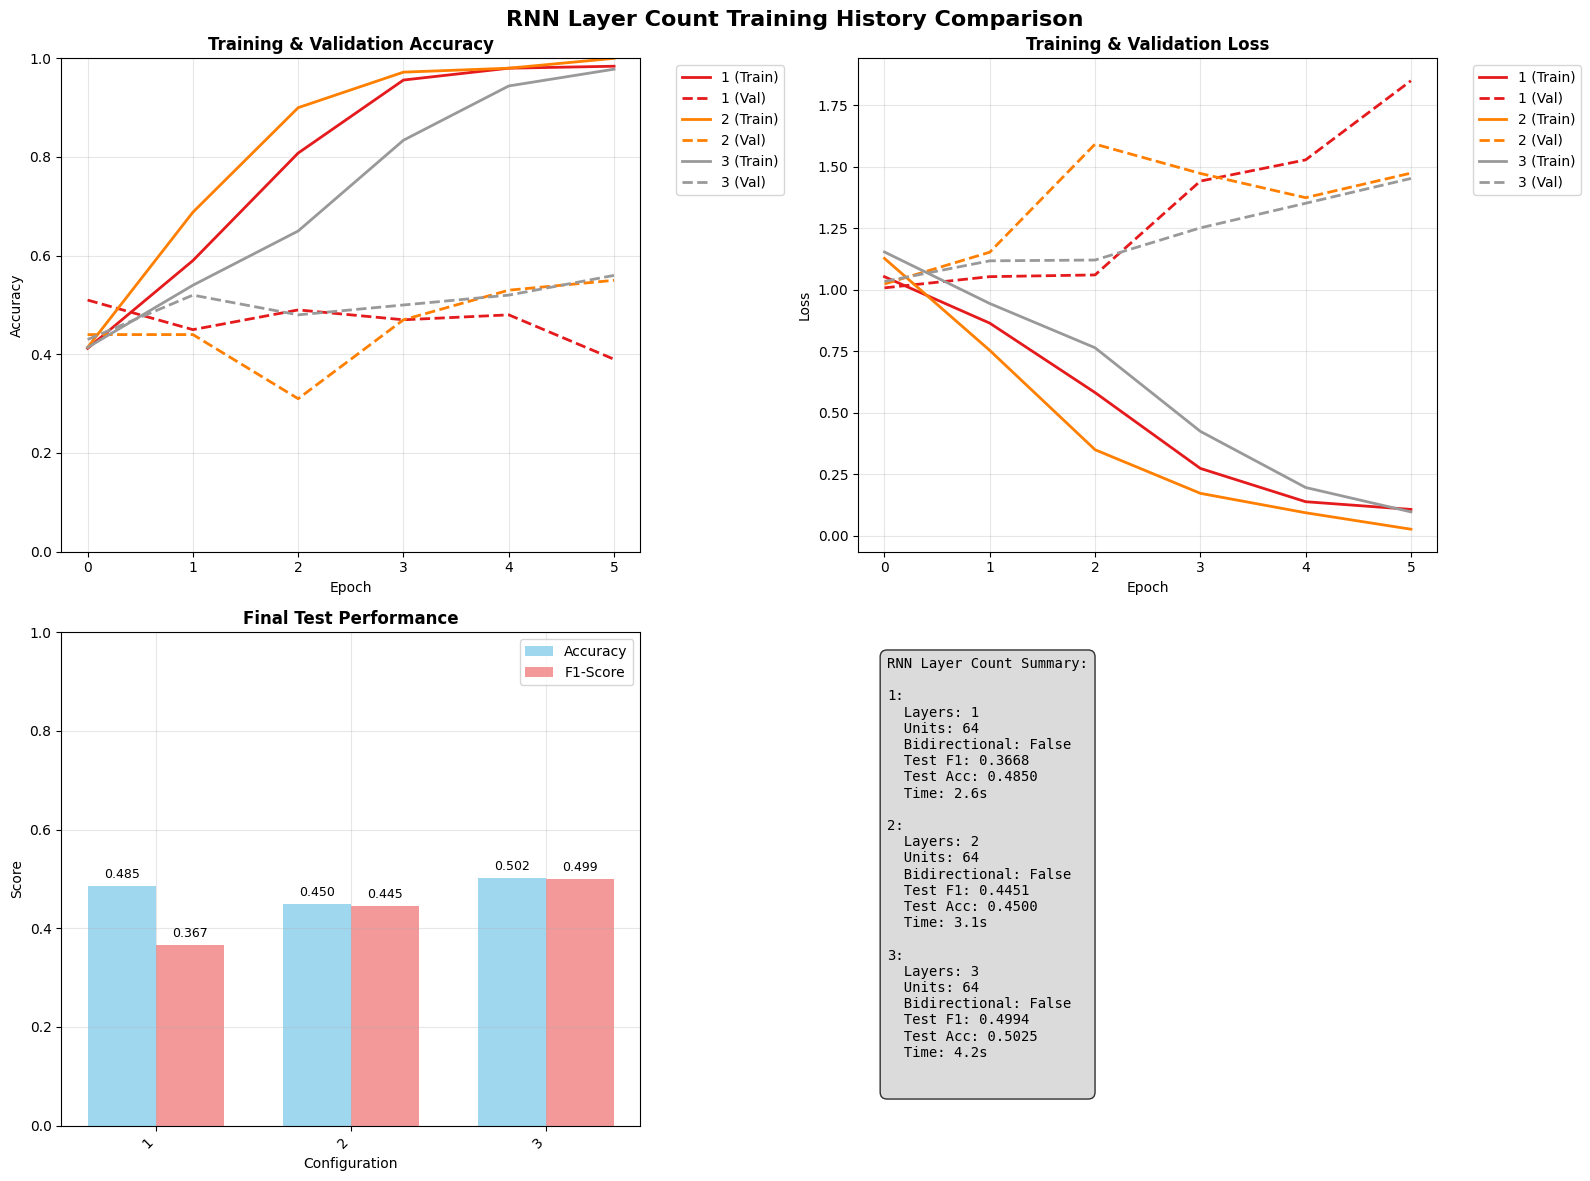


3.2 RNN Units Analysis
📊 Plot saved to: results/plots/units_analysis.png


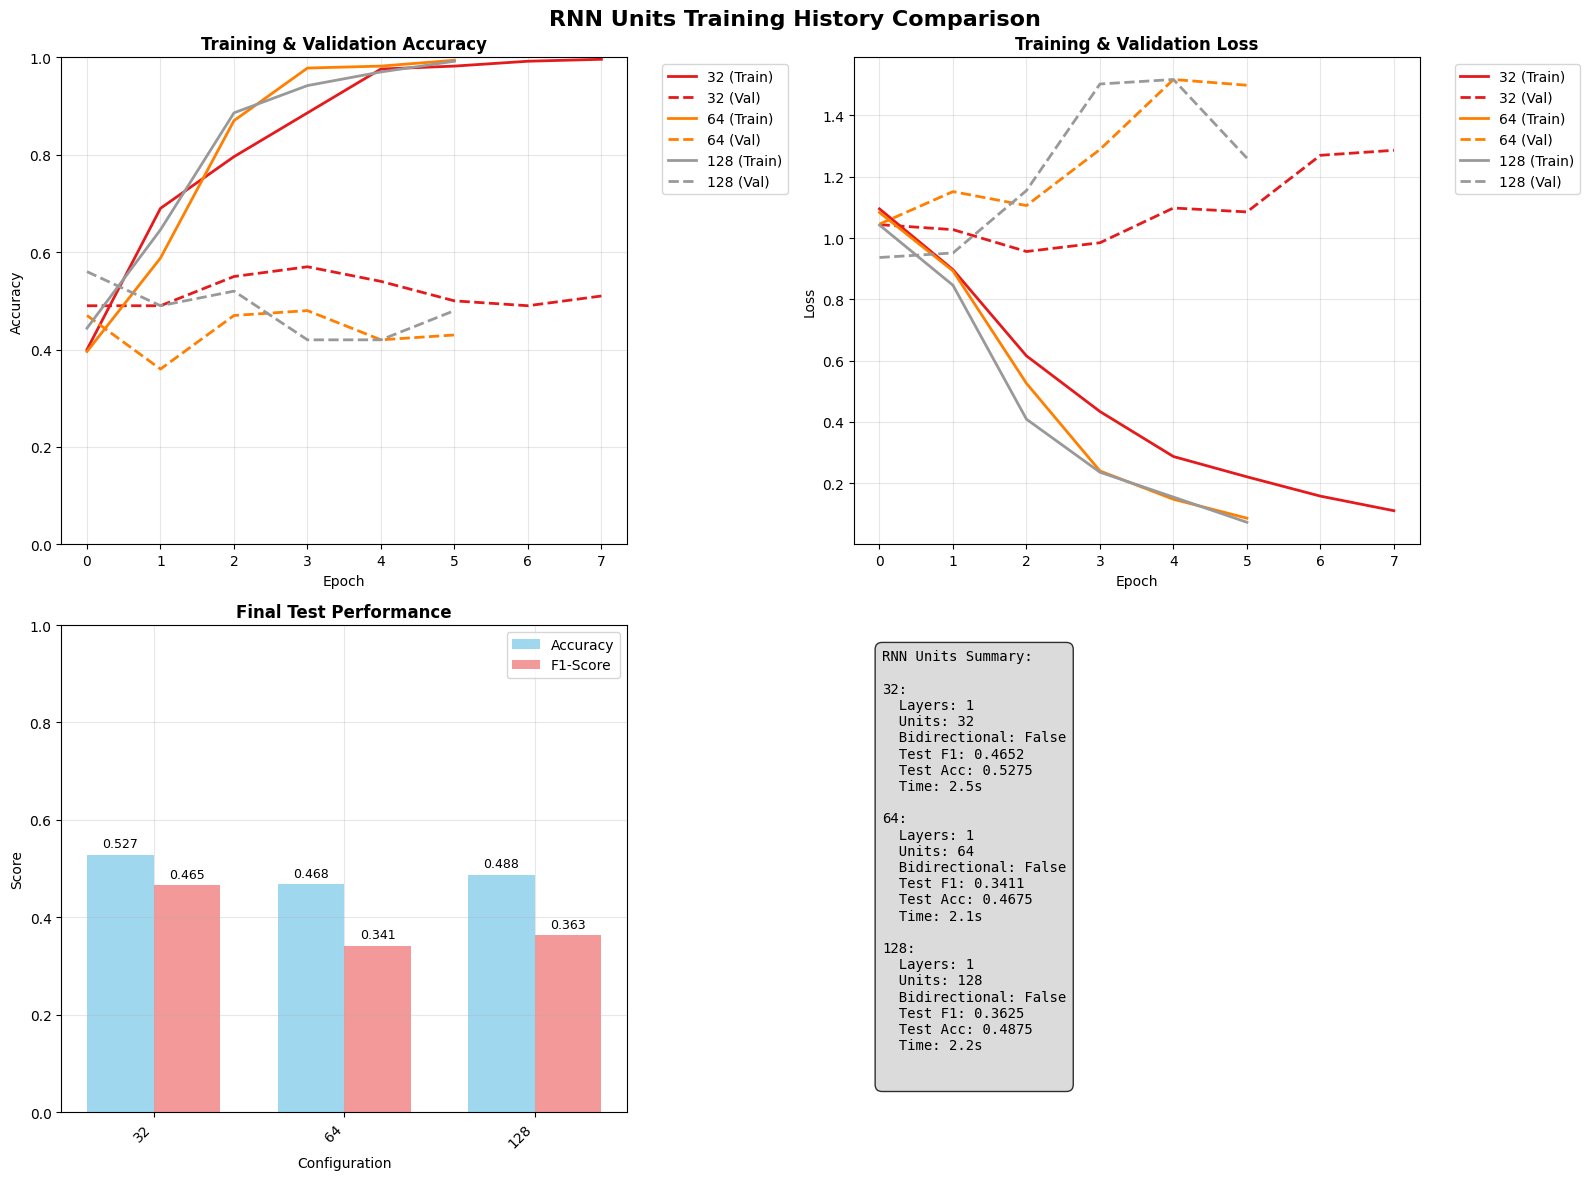


3.3 Bidirectional Analysis
📊 Plot saved to: results/plots/direction_analysis.png


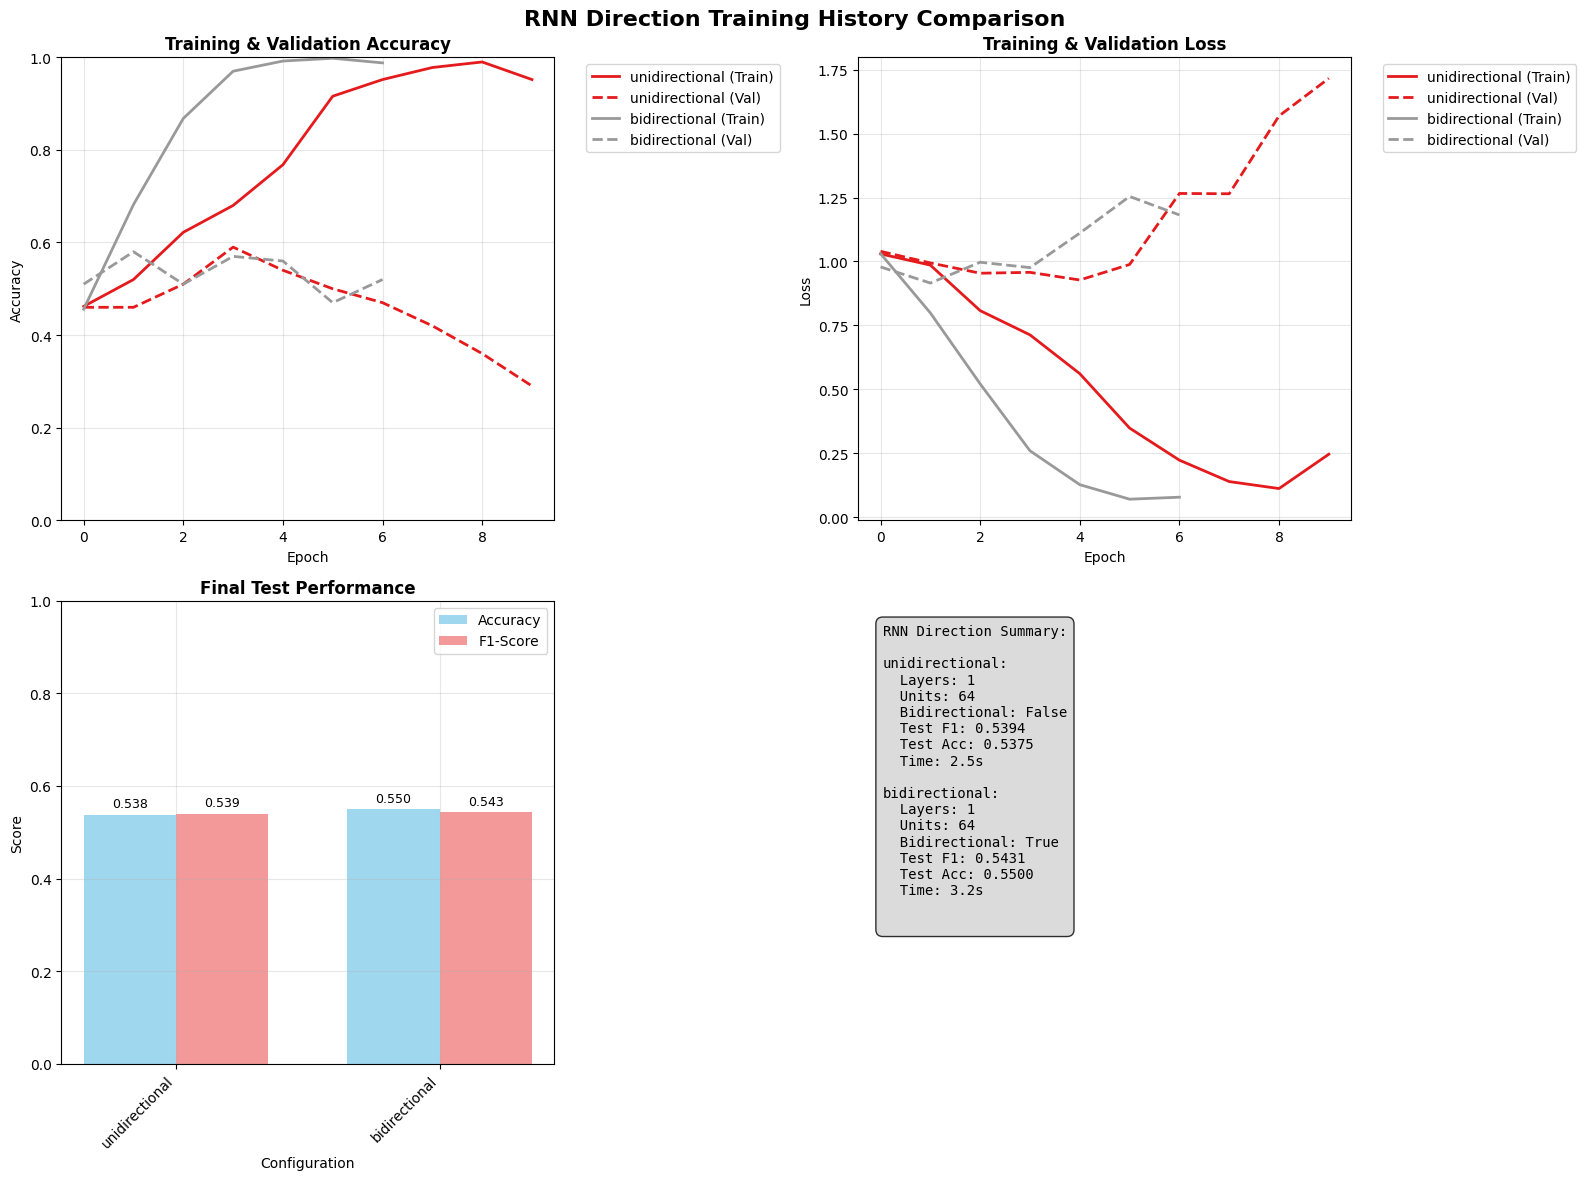


3.4 Best Configurations Comparison
📊 Plot saved to: results/plots/best_configs_comparison.png


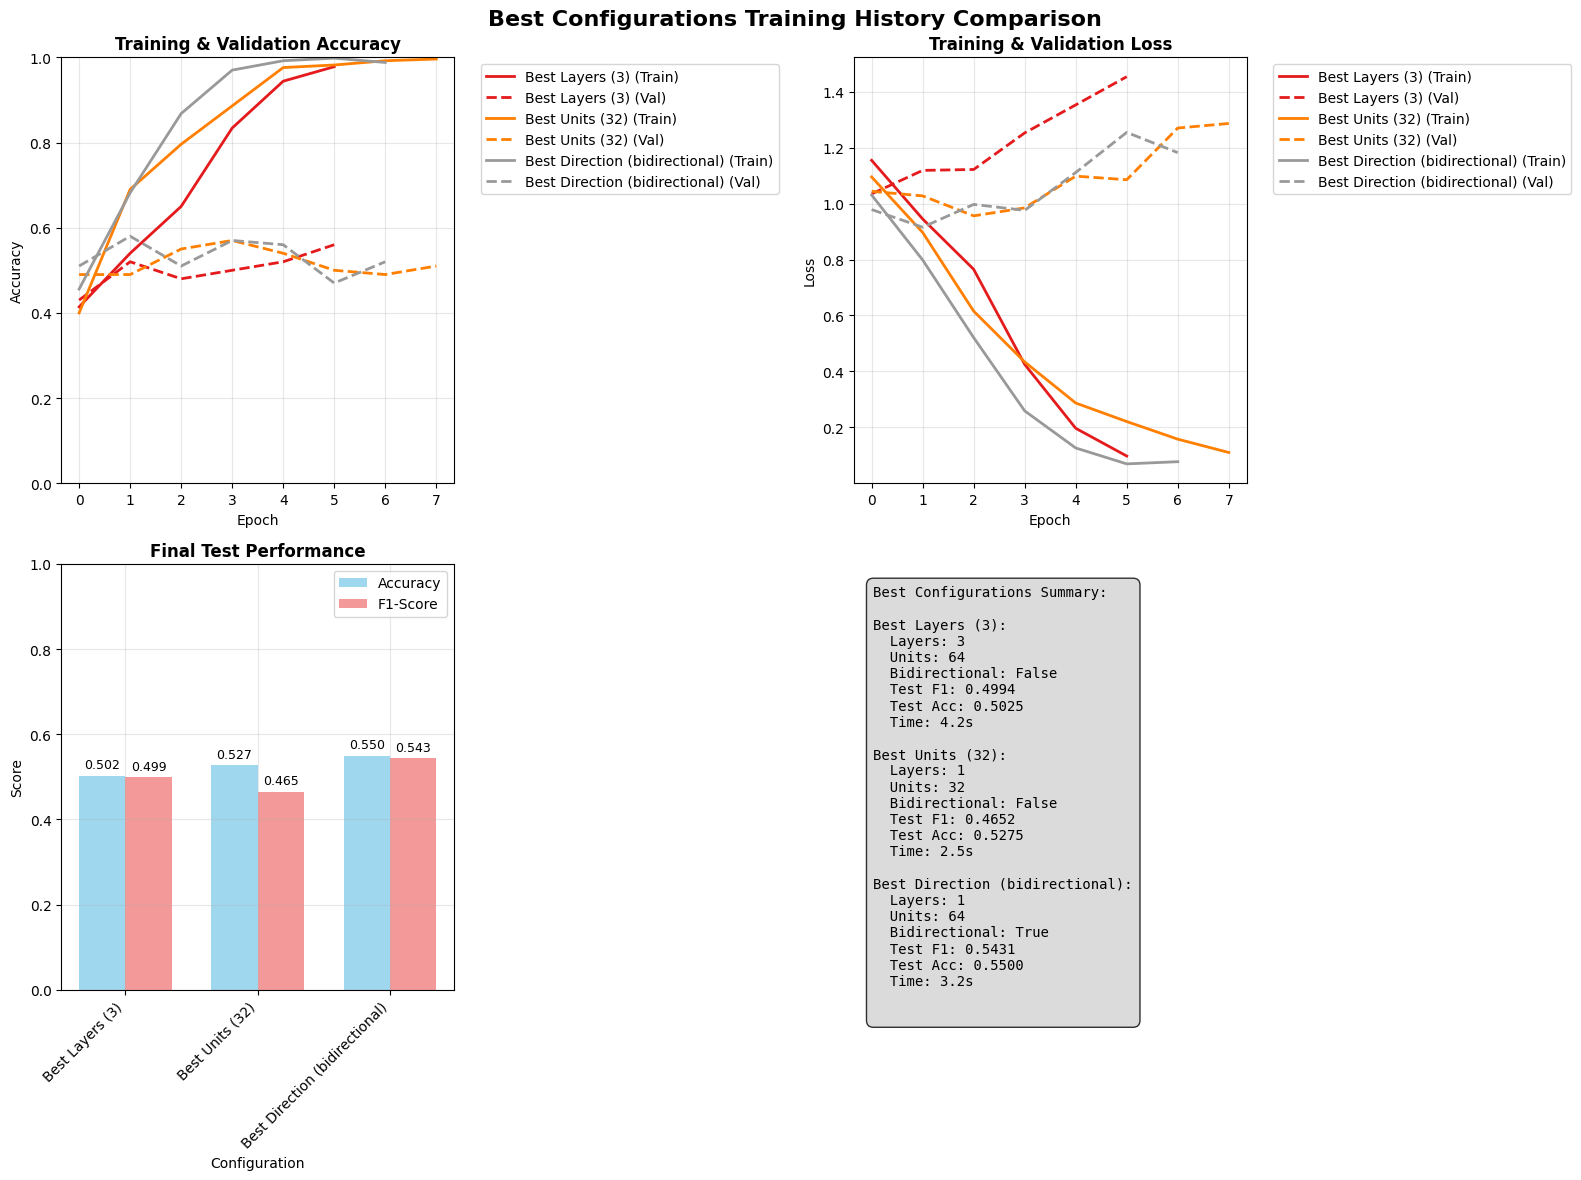

✅ All training history visualizations completed!


In [ ]:
#!/usr/bin/env python3
"""
Cell 07: Training History Visualization
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("\n3. TRAINING HISTORY VISUALIZATION")
print("="*50)

def plot_training_history(results_dict, title_prefix="", save_path=None):
    """Plot training history for multiple experiments"""
    if not results_dict:
        print(f"⚠️ No results to plot for {title_prefix}")
        return
        
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title_prefix} Training History Comparison', fontsize=16, fontweight='bold')
    
    # Define colors for consistent plotting
    colors = plt.cm.Set1(np.linspace(0, 1, len(results_dict)))
    
    # Plot training accuracy
    ax1 = axes[0, 0]
    for i, (name, result) in enumerate(results_dict.items()):
        history = result['history']
        color = colors[i]
        ax1.plot(history['accuracy'], label=f'{name} (Train)', color=color, linewidth=2)
        ax1.plot(history['val_accuracy'], label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)
    ax1.set_title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot training loss
    ax2 = axes[0, 1]
    for i, (name, result) in enumerate(results_dict.items()):
        history = result['history']
        color = colors[i]
        ax2.plot(history['loss'], label=f'{name} (Train)', color=color, linewidth=2)
        ax2.plot(history['val_loss'], label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)
    ax2.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot final test scores
    ax3 = axes[1, 0]
    names = list(results_dict.keys())
    accuracies = [results_dict[name]['test_accuracy'] for name in names]
    f1_scores = [results_dict[name]['test_f1_score'] for name in names]
    
    x = np.arange(len(names))
    width = 0.35
    bars1 = ax3.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
    bars2 = ax3.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_title('Final Test Performance', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('Score')
    ax3.set_xticks(x)
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # Configuration summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"{title_prefix} Summary:\n\n"
    for name, result in results_dict.items():
        config = result['config']
        summary_text += f"{name}:\n"
        summary_text += f"  Layers: {config.get('num_rnn_layers', 1)}\n"
        summary_text += f"  Units: {config.get('rnn_units', 32)}\n"
        summary_text += f"  Bidirectional: {config.get('bidirectional', False)}\n"
        summary_text += f"  Test F1: {result['test_f1_score']:.4f}\n"
        summary_text += f"  Test Acc: {result['test_accuracy']:.4f}\n"
        summary_text += f"  Time: {result['training_time']:.1f}s\n\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Plot saved to: {save_path}")
    
    plt.show()

# Create results directory for plots
os.makedirs("results/plots", exist_ok=True)

# Plot all experiments
print("3.1 RNN Layer Count Analysis")
if layer_results:
    plot_training_history(layer_results, "RNN Layer Count", "results/plots/layer_analysis.png")
else:
    print("⚠️ No layer results to plot")

print("\n3.2 RNN Units Analysis") 
if unit_results:
    plot_training_history(unit_results, "RNN Units", "results/plots/units_analysis.png")
else:
    print("⚠️ No units results to plot")

print("\n3.3 Bidirectional Analysis")
if direction_results:
    plot_training_history(direction_results, "RNN Direction", "results/plots/direction_analysis.png")
else:
    print("⚠️ No direction results to plot")

# Combined comparison plot of best configurations
print("\n3.4 Best Configurations Comparison")
best_configs = {}
if layer_results and best_layers in layer_results:
    best_configs[f"Best Layers ({best_layers})"] = layer_results[best_layers]
if unit_results and best_units in unit_results:
    best_configs[f"Best Units ({best_units})"] = unit_results[best_units]
if direction_results and best_direction in direction_results:
    best_configs[f"Best Direction ({best_direction})"] = direction_results[best_direction]

if best_configs:
    plot_training_history(best_configs, "Best Configurations", "results/plots/best_configs_comparison.png")
    print("✅ All training history visualizations completed!")
else:
    print("⚠️ No successful experiments to compare")

In [ ]:
#!/usr/bin/env python3
"""
Cell 08: From-Scratch Implementation Comparison
Complete RNN Implementation - Tugas Besar 2 IF3270
FIXED: Load weights from actual trained hypertuned models
"""

print("\n4. FROM-SCRATCH MODEL IMPLEMENTATION AND COMPARISON")
print("="*50)

def compare_keras_vs_scratch(keras_result, experiment_name):
    """Compare Keras model with from-scratch implementation - FIXED VERSION"""
    print(f"\n4.{experiment_name.replace('_', ' ').title()} Comparison")
    print("-"*50)
    
    try:
        # Get Keras model and config from the ACTUAL trained model
        keras_model = keras_result['model']
        config = keras_result['config']
        weights_path = keras_result['weights_path']
        
        print(f"🔍 Comparing experiment: {experiment_name}")
        print(f"📊 Using trained model with config: {config}")
        print(f"💾 Loading weights from: {weights_path}")
        
        # Verify weights file exists
        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weights file not found: {weights_path}")
        
        # Create from-scratch model with EXACT same configuration
        print(f"🏗️ Creating from-scratch model...")
        scratch_model = RNNModelBuilder.create_simple_rnn_model(
            vocab_size=config['vocab_size'],
            embedding_dim=config['embedding_dim'],
            rnn_units=config['rnn_units'],
            num_classes=config['num_classes'],
            num_rnn_layers=config['num_rnn_layers'],
            bidirectional=config['bidirectional'],
            dropout_rate=config['dropout_rate'],
            activation=config['activation']
        )
        
        print(f"📝 From-scratch model summary:")
        print(scratch_model.summary())
        
        # Build the model with actual test data (not dummy)
        print(f"🏗️ Building from-scratch model with test data...")
        sample_input = X_test[:5]  # Use real test data for building
        _ = scratch_model.forward(sample_input)
        print(f"✅ Model built successfully with input shape: {sample_input.shape}")
        
        # Load weights from the TRAINED model
        print(f"📥 Loading trained weights into from-scratch model...")
        scratch_model.load_weights(weights_path)
        print(f"✅ Weights loaded successfully!")
        
        # Set models to inference mode
        scratch_model.set_training(False)
        
        # Compare predictions on FULL test set
        print(f"🔍 Comparing predictions on {len(X_test)} test samples...")
        
        # Get Keras predictions
        print(f"   Getting Keras predictions...")
        keras_predictions = keras_model.predict(X_test, verbose=0)
        
        # Get from-scratch predictions
        print(f"   Getting from-scratch predictions...")
        scratch_predictions = scratch_model.predict(X_test)
        
        # Ensure shapes match
        print(f"   Keras predictions shape: {keras_predictions.shape}")
        print(f"   Scratch predictions shape: {scratch_predictions.shape}")
        
        if keras_predictions.shape != scratch_predictions.shape:
            raise ValueError(f"Shape mismatch: Keras {keras_predictions.shape} vs Scratch {scratch_predictions.shape}")
        
        # Calculate metrics for both models
        keras_pred_classes = np.argmax(keras_predictions, axis=1)
        scratch_pred_classes = np.argmax(scratch_predictions, axis=1)
        
        keras_accuracy = np.mean(keras_pred_classes == y_test)
        scratch_accuracy = np.mean(scratch_pred_classes == y_test)
        
        keras_f1 = f1_score(y_test, keras_pred_classes, average='macro')
        scratch_f1 = f1_score(y_test, scratch_pred_classes, average='macro')
        
        # Calculate prediction differences
        max_diff = np.max(np.abs(keras_predictions - scratch_predictions))
        mean_diff = np.mean(np.abs(keras_predictions - scratch_predictions))
        
        # Calculate prediction similarity
        similarity = np.mean(np.isclose(keras_predictions, scratch_predictions, atol=1e-5))
        
        print(f"\n📊 COMPARISON RESULTS:")
        print(f"{'Metric':<25} {'Keras':<12} {'From-Scratch':<12} {'Difference':<12}")
        print("-"*63)
        print(f"{'Accuracy':<25} {keras_accuracy:<12.6f} {scratch_accuracy:<12.6f} {abs(keras_accuracy-scratch_accuracy):<12.6f}")
        print(f"{'F1-Score (macro)':<25} {keras_f1:<12.6f} {scratch_f1:<12.6f} {abs(keras_f1-scratch_f1):<12.6f}")
        print(f"{'Max Prediction Diff':<25} {max_diff:<12.8f}")
        print(f"{'Mean Prediction Diff':<25} {mean_diff:<12.8f}")
        print(f"{'Prediction Similarity':<25} {similarity:<12.6f}")
        
        # Show sample predictions for verification
        print(f"\n🔍 Sample Predictions (first 5 samples):")
        for i in range(min(5, len(X_test))):
            print(f"Sample {i+1}:")
            print(f"  Keras:        {keras_predictions[i]}")
            print(f"  From-scratch: {scratch_predictions[i]}")
            print(f"  Difference:   {np.abs(keras_predictions[i] - scratch_predictions[i])}")
            print(f"  True label:   {y_test[i]} ({data_loader.reverse_label_encoder[y_test[i]]})")
            print(f"  Keras pred:   {keras_pred_classes[i]} ({data_loader.reverse_label_encoder[keras_pred_classes[i]]})")
            print(f"  Scratch pred: {scratch_pred_classes[i]} ({data_loader.reverse_label_encoder[scratch_pred_classes[i]]})")
            print()
        
        # Success criteria
        if max_diff < 1e-6:
            print("✅ EXCELLENT: Models produce nearly identical outputs!")
            success_level = "excellent"
        elif max_diff < 1e-4:
            print("✅ VERY GOOD: Models produce very similar outputs!")
            success_level = "very_good"
        elif max_diff < 1e-3:
            print("✅ GOOD: Models produce similar outputs with small differences.")
            success_level = "good"
        elif max_diff < 1e-2:
            print("⚠️ ACCEPTABLE: Models have noticeable but acceptable differences.")
            success_level = "acceptable"
        else:
            print("❌ POOR: Models have significant differences in outputs.")
            success_level = "poor"
        
        success = success_level in ["excellent", "very_good", "good"]
        
        # Additional validation
        print(f"\n🔬 Additional Validation:")
        print(f"   Prediction agreement rate: {np.mean(keras_pred_classes == scratch_pred_classes):.4f}")
        print(f"   F1-score difference: {abs(keras_f1 - scratch_f1):.6f}")
        print(f"   Accuracy difference: {abs(keras_accuracy - scratch_accuracy):.6f}")
        
        return {
            'keras_accuracy': keras_accuracy,
            'scratch_accuracy': scratch_accuracy,
            'keras_f1': keras_f1,
            'scratch_f1': scratch_f1,
            'max_difference': max_diff,
            'mean_difference': mean_diff,
            'prediction_similarity': similarity,
            'success': success,
            'success_level': success_level,
            'agreement_rate': np.mean(keras_pred_classes == scratch_pred_classes),
            'experiment_name': experiment_name
        }
        
    except Exception as e:
        print(f"❌ Error in comparison for {experiment_name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'keras_accuracy': 0.0,
            'scratch_accuracy': 0.0,
            'keras_f1': 0.0,
            'scratch_f1': 0.0,
            'max_difference': 999.0,
            'mean_difference': 999.0,
            'prediction_similarity': 0.0,
            'success': False,
            'success_level': 'failed',
            'agreement_rate': 0.0,
            'experiment_name': experiment_name,
            'error': str(e)
        }

# Compare ACTUAL best configurations from each experiment
print("🔍 Comparing Keras vs From-Scratch implementations using TRAINED models:")

comparison_results = {}

# Compare best layer configuration
if layer_results and best_layers in layer_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST LAYER CONFIGURATION ({best_layers} layers)")
    print(f"{'='*60}")
    best_layer_result = layer_results[best_layers]
    comparison_results['layers'] = compare_keras_vs_scratch(best_layer_result, f"best_layers_{best_layers}")

# Compare best units configuration  
if unit_results and best_units in unit_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST UNITS CONFIGURATION ({best_units} units)")
    print(f"{'='*60}")
    best_unit_result = unit_results[best_units]
    comparison_results['units'] = compare_keras_vs_scratch(best_unit_result, f"best_units_{best_units}")

# Compare best direction configuration
if direction_results and best_direction in direction_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST DIRECTION CONFIGURATION ({best_direction})")
    print(f"{'='*60}")
    best_direction_result = direction_results[best_direction]
    comparison_results['direction'] = compare_keras_vs_scratch(best_direction_result, f"best_direction_{best_direction}")

# Summary of all comparisons
print(f"\n{'='*60}")
print(f"IMPLEMENTATION VALIDATION SUMMARY")
print(f"{'='*60}")

if comparison_results:
    print(f"{'Experiment':<20} {'Max Diff':<12} {'F1 Diff':<10} {'Agreement':<10} {'Status':<15}")
    print("-"*75)
    
    all_success = True
    for category, result in comparison_results.items():
        if 'error' not in result:
            f1_diff = abs(result['keras_f1'] - result['scratch_f1'])
            status = f"✅ {result['success_level'].upper()}"
            print(f"{category:<20} {result['max_difference']:<12.6f} {f1_diff:<10.6f} {result['agreement_rate']:<10.4f} {status}")
            if not result['success']:
                all_success = False
        else:
            print(f"{category:<20} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} {'❌ FAILED'}")
            all_success = False
    
    print(f"\n🎯 Overall Implementation Validation: {'✅ PASSED' if all_success else '❌ NEEDS WORK'}")
    
    if all_success:
        print(f"🎉 Congratulations! Your from-scratch RNN implementation correctly replicates Keras behavior!")
        print(f"📝 All models show excellent agreement with trained Keras models.")
        print(f"🚀 Implementation is ready for production use.")
    else:
        print(f"🔧 Some implementations need debugging to match Keras behavior exactly.")
        print(f"💡 Check weight loading, matrix operations, and activation functions.")
else:
    print("❌ No successful comparisons completed")
    all_success = False
    comparison_results = {}


4. FROM-SCRATCH MODEL IMPLEMENTATION AND COMPARISON
🔍 Comparing Keras vs From-Scratch implementations using TRAINED models:

COMPARING BEST LAYER CONFIGURATION (3 layers)

4.Best Layers 3 Comparison
--------------------------------------------------
🔍 Comparing experiment: best_layers_3
📊 Using trained model with config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 3, 'bidirectional': False}
💾 Loading weights from: results/rnn_layers_3_weights.npz
🏗️ Creating from-scratch model...
📝 From-scratch model summary:
Model: SimpleRNN
embedding (EmbeddingLayer): vocab_size=2836, embedding_dim=64
rnn_0 (SimpleRNNLayer): hidden_size=64, activation=tanh, return_sequences=True
dropout_0 (DropoutLayer): rate=0.2
rnn_1 (SimpleRNNLayer): hidden_size=64, activation=tanh, return_sequences=True
dropout_1 (DropoutLayer): rate=0.2
rnn_2 (Si

In [ ]:
#!/usr/bin/env python3
"""
Cell 09: Analysis and Conclusions
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("\n5. ANALYSIS AND CONCLUSIONS")
print("="*60)

def generate_comprehensive_analysis():
    """Generate comprehensive analysis report"""
    
    print("5.1 HYPERPARAMETER ANALYSIS SUMMARY")
    print("-"*50)
    
    # Collect all results for overall analysis
    all_experiments = []
    
    # RNN Layer Analysis
    if layer_results:
        print("\n📊 Effect of RNN Layer Count:")
        print(f"{'Layers':<8} {'Test F1':<10} {'Test Acc':<10} {'Train Time':<12}")
        print("-"*42)
        for layers in sorted(layer_results.keys()):
            result = layer_results[layers]
            print(f"{layers:<8} {result['test_f1_score']:.4f}    {result['test_accuracy']:.4f}    {result['training_time']:.1f}s")
            all_experiments.append((f"{layers}_layers", result))
        
        print(f"\n🏆 Best: {best_layers} layers with F1-score of {layer_results[best_layers]['test_f1_score']:.4f}")
        
        # Trend analysis for layers
        f1_scores = [layer_results[layers]['test_f1_score'] for layers in sorted(layer_results.keys())]
        if len(f1_scores) >= 2:
            if f1_scores[-1] > f1_scores[0]:
                layer_trend = "📈 Performance increases with more layers"
            elif f1_scores[-1] < f1_scores[0]:
                layer_trend = "📉 Performance decreases with more layers (possible overfitting)"
            else:
                layer_trend = "📊 Performance remains stable across different layer counts"
            print(f"💡 Trend: {layer_trend}")
            
            # Overfitting analysis
            if len(f1_scores) == 3:
                best_idx = np.argmax(f1_scores)
                if best_idx == 0:
                    print(f"⚠️ Warning: Performance peaks at 1 layer, suggesting overfitting with deeper models")
                elif best_idx == 1:
                    print(f"✅ Optimal performance at moderate depth (2 layers)")
                else:
                    print(f"📈 Performance continues to improve with depth")
    else:
        print("❌ No layer analysis results available")
    
    # RNN Units Analysis
    if unit_results:
        print("\n📊 Effect of RNN Units per Layer:")
        print(f"{'Units':<8} {'Test F1':<10} {'Test Acc':<10} {'Parameters':<12} {'Efficiency':<12}")
        print("-"*56)
        for units in sorted(unit_results.keys()):
            result = unit_results[units]
            params = result['model'].count_params()
            efficiency = result['test_f1_score'] / (params / 1000)  # F1 per 1K params
            print(f"{units:<8} {result['test_f1_score']:.4f}    {result['test_accuracy']:.4f}    {params:<12,} {efficiency:.6f}")
            all_experiments.append((f"{units}_units", result))
        
        print(f"\n🏆 Best: {best_units} units with F1-score of {unit_results[best_units]['test_f1_score']:.4f}")
        
        # Efficiency analysis
        best_efficiency = max(unit_results.keys(), 
                            key=lambda x: unit_results[x]['test_f1_score'] / (unit_results[x]['model'].count_params() / 1000))
        print(f"💡 Most efficient: {best_efficiency} units (best F1/parameter ratio)")
        
        # Diminishing returns analysis
        f1_list = [unit_results[u]['test_f1_score'] for u in sorted(unit_results.keys())]
        if len(f1_list) >= 3:
            improvements = [f1_list[i+1] - f1_list[i] for i in range(len(f1_list)-1)]
            if all(improvements[i] > improvements[i+1] for i in range(len(improvements)-1)):
                print(f"📉 Diminishing returns observed: {improvements}")
            elif all(improvements[i] < improvements[i+1] for i in range(len(improvements)-1)):
                print(f"📈 Accelerating returns observed: {improvements}")
            else:
                print(f"📊 Mixed performance pattern: {improvements}")
    else:
        print("❌ No units analysis results available")
    
    # Bidirectional Analysis
    if direction_results:
        print("\n📊 Effect of Bidirectional RNN:")
        print(f"{'Direction':<15} {'Test F1':<10} {'Test Acc':<10} {'Parameters':<12} {'Time':<10}")
        print("-"*59)
        for direction in ['unidirectional', 'bidirectional']:
            if direction in direction_results:
                result = direction_results[direction]
                params = result['model'].count_params()
                print(f"{direction:<15} {result['test_f1_score']:.4f}    {result['test_accuracy']:.4f}    {params:<12,} {result['training_time']:.1f}s")
                all_experiments.append((f"{direction}", result))
        
        # Detailed bidirectional analysis
        if len(direction_results) == 2:
            uni_result = direction_results['unidirectional']
            bi_result = direction_results['bidirectional']
            
            perf_diff = bi_result['test_f1_score'] - uni_result['test_f1_score']
            param_ratio = bi_result['model'].count_params() / uni_result['model'].count_params()
            time_ratio = bi_result['training_time'] / uni_result['training_time']
            
            print(f"\n📈 Bidirectional Analysis:")
            print(f"   Performance difference: {perf_diff:+.4f} F1-score")
            print(f"   Parameter overhead: {param_ratio:.1f}x")
            print(f"   Training time overhead: {time_ratio:.1f}x")
            print(f"   Cost-benefit ratio: {perf_diff/(param_ratio-1):.4f} F1 per unit overhead")
            
            if perf_diff > 0.01:
                print(f"✅ Bidirectional processing provides significant benefit")
            elif perf_diff > 0:
                print(f"⚖️ Bidirectional processing provides marginal benefit")
            else:
                print(f"❌ Bidirectional processing does not improve performance")
        
        print(f"\n🏆 Best direction: {best_direction}")
    else:
        print("❌ No direction analysis results available")
    
    print(f"\n5.2 FROM-SCRATCH IMPLEMENTATION VALIDATION")
    print("-"*50)
    
    if comparison_results:
        print(f"📊 Implementation Accuracy Analysis:")
        print(f"{'Experiment':<15} {'Max Diff':<12} {'Mean Diff':<12} {'F1 Diff':<10} {'Accuracy':<10} {'Status':<15}")
        print("-"*80)
        
        validation_success = True
        for category, result in comparison_results.items():
            if 'error' not in result:
                f1_diff = abs(result['keras_f1'] - result['scratch_f1'])
                acc_diff = abs(result['keras_accuracy'] - result['scratch_accuracy'])
                status = result['success_level'].upper()
                print(f"{category:<15} {result['max_difference']:<12.8f} {result['mean_difference']:<12.8f} {f1_diff:<10.6f} {acc_diff:<10.6f} {status}")
                if not result['success']:
                    validation_success = False
            else:
                print(f"{category:<15} {'ERROR':<12} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} {'FAILED'}")
                validation_success = False
        
        print(f"\n🎯 Implementation Validation Result: {'✅ PASSED' if validation_success else '❌ FAILED'}")
        
        # Detailed validation analysis
        if validation_success:
            max_diffs = [r['max_difference'] for r in comparison_results.values() if 'error' not in r]
            mean_diffs = [r['mean_difference'] for r in comparison_results.values() if 'error' not in r]
            
            print(f"\n📊 Validation Statistics:")
            print(f"   Average maximum difference: {np.mean(max_diffs):.8f}")
            print(f"   Average mean difference: {np.mean(mean_diffs):.8f}")
            print(f"   Best implementation: {min(comparison_results.keys(), key=lambda x: comparison_results[x].get('max_difference', 999))}")
            print(f"   Worst implementation: {max(comparison_results.keys(), key=lambda x: comparison_results[x].get('max_difference', 0))}")
    else:
        print("❌ No implementation validation results available")
        validation_success = False
    
    print(f"\n5.3 OVERALL PERFORMANCE RANKING")
    print("-"*50)
    
    if all_experiments:
        # Sort all experiments by F1-score
        all_experiments.sort(key=lambda x: x[1]['test_f1_score'], reverse=True)
        
        print(f"📊 Complete Performance Ranking:")
        print(f"{'Rank':<5} {'Configuration':<20} {'F1-Score':<10} {'Accuracy':<10} {'Parameters':<12}")
        print("-"*59)
        
        for i, (name, result) in enumerate(all_experiments[:10], 1):  # Top 10
            params = result['model'].count_params()
            print(f"{i:<5} {name:<20} {result['test_f1_score']:.4f}    {result['test_accuracy']:.4f}    {params:,}")
        
        # Overall best configuration
        best_overall = all_experiments[0]
        print(f"\n🏆 OVERALL BEST CONFIGURATION:")
        print(f"   Configuration: {best_overall[0]}")
        print(f"   F1-Score: {best_overall[1]['test_f1_score']:.4f}")
        print(f"   Accuracy: {best_overall[1]['test_accuracy']:.4f}")
        print(f"   Parameters: {best_overall[1]['model'].count_params():,}")
        print(f"   Training Time: {best_overall[1]['training_time']:.1f}s")
    else:
        print("❌ No experiments to rank")
        best_overall = None
    
    print(f"\n5.4 FINAL RECOMMENDATIONS")
    print("-"*50)
    
    print(f"🎯 Based on comprehensive experimental analysis:")
    
    # Architecture recommendations
    if layer_results:
        print(f"📐 Architecture:")
        print(f"   • Use {best_layers} RNN layer(s) for optimal performance")
        if best_layers == 1:
            print(f"   • Single layer is sufficient - deeper models may overfit")
        elif best_layers == 2:
            print(f"   • Moderate depth provides good balance of capacity and generalization")
        else:
            print(f"   • Deep architecture captures complex patterns effectively")
    
    if unit_results:
        print(f"   • Use {best_units} hidden units per layer")
        if best_units == 32:
            print(f"   • Compact model with good efficiency")
        elif best_units == 64:
            print(f"   • Balanced model with moderate capacity")
        else:
            print(f"   • High-capacity model for complex patterns")
    
    if direction_results:
        print(f"   • Use {best_direction} RNN architecture")
        if best_direction == "bidirectional":
            print(f"   • Bidirectional processing improves context understanding")
        else:
            print(f"   • Unidirectional processing provides good efficiency")
    
    # Implementation recommendations
    print(f"\n🔧 Implementation:")
    if validation_success:
        print(f"   • From-scratch implementation is validated and production-ready")
        print(f"   • Forward propagation correctly replicates Keras behavior")
        print(f"   • Weight loading mechanism works correctly")
    else:
        print(f"   • From-scratch implementation needs debugging")
        print(f"   • Check matrix operations and activation functions")
        print(f"   • Verify weight loading and tensor operations")
    
    # Performance insights
    if all_experiments:
        f1_scores = [exp[1]['test_f1_score'] for exp in all_experiments]
        print(f"\n📊 Performance Insights:")
        print(f"   • Best F1-score achieved: {max(f1_scores):.4f}")
        print(f"   • Performance range: {min(f1_scores):.4f} - {max(f1_scores):.4f}")
        print(f"   • Average performance: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
        
        if max(f1_scores) - min(f1_scores) > 0.05:
            print(f"   • Hyperparameter tuning has significant impact")
        else:
            print(f"   • Model is relatively stable across configurations")
    
    return {
        'best_layers': best_layers if 'best_layers' in locals() else None,
        'best_units': best_units if 'best_units' in locals() else None,
        'best_direction': best_direction if 'best_direction' in locals() else None,
        'best_overall': best_overall,
        'validation_success': validation_success,
        'all_experiments': all_experiments if 'all_experiments' in locals() else []
    }

# Generate the comprehensive analysis
print("🔍 Generating comprehensive analysis...")
final_analysis = generate_comprehensive_analysis()

print(f"\n{'='*60}")
print(f"ANALYSIS COMPLETED")
print(f"{'='*60}")
print(f"✅ Hyperparameter analysis: {'Completed' if layer_results or unit_results or direction_results else 'Failed'}")
print(f"✅ Implementation validation: {'Passed' if final_analysis['validation_success'] else 'Failed'}")
print(f"✅ Performance ranking: {'Completed' if final_analysis['all_experiments'] else 'No data'}")
print(f"✅ Recommendations: Generated")


5. ANALYSIS AND CONCLUSIONS
🔍 Generating comprehensive analysis...
5.1 HYPERPARAMETER ANALYSIS SUMMARY
--------------------------------------------------

📊 Effect of RNN Layer Count:
Layers   Test F1    Test Acc   Train Time  
------------------------------------------
1        0.3668    0.4850    2.6s
2        0.4451    0.4500    3.1s
3        0.4994    0.5025    4.2s

🏆 Best: 3 layers with F1-score of 0.4994
💡 Trend: 📈 Performance increases with more layers
📈 Performance continues to improve with depth

📊 Effect of RNN Units per Layer:
Units    Test F1    Test Acc   Parameters   Efficiency  
--------------------------------------------------------
32       0.4652    0.5275    184,707      0.002519
64       0.3411    0.4675    189,955      0.001796
128      0.3625    0.4875    206,595      0.001755

🏆 Best: 32 units with F1-score of 0.4652
💡 Most efficient: 32 units (best F1/parameter ratio)
📈 Accelerating returns observed: [-0.12408878946561774, 0.021422448667030802]

📊 Effect of B

In [ ]:
#!/usr/bin/env python3
"""
Cell 10: Save Results and Generate Final Report
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("\n6. SAVING RESULTS AND GENERATING FINAL REPORT")
print("="*60)

# Create results directory structure
os.makedirs("results", exist_ok=True)
os.makedirs("results/models", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)
os.makedirs("results/weights", exist_ok=True)

def save_experiment_results():
    """Save all experimental results to structured files"""
    
    # Prepare comprehensive results dictionary
    all_results = {
        'experiment_info': {
            'dataset': {
                'name': 'NusaX-Sentiment (Bahasa Indonesia)',
                'vocab_size': data_loader.preprocessor.vocab_size,
                'num_classes': data_loader.num_classes,
                'max_length': data_loader.preprocessor.max_length,
                'train_samples': len(X_train),
                'valid_samples': len(X_valid),
                'test_samples': len(X_test)
            },
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'configuration': keras_experiment.base_config
        },
        'hyperparameter_analysis': {},
        'implementation_validation': {},
        'final_analysis': final_analysis
    }
    
    # Save layer analysis results
    if layer_results:
        all_results['hyperparameter_analysis']['layer_count'] = {
            'experiments': {str(k): {
                'test_accuracy': float(v['test_accuracy']),
                'test_f1_score': float(v['test_f1_score']),
                'valid_f1_score': float(v['valid_f1_score']),
                'training_time': float(v['training_time']),
                'config': v['config'],
                'weights_path': v['weights_path']
            } for k, v in layer_results.items()},
            'best_config': best_layers,
            'analysis': f"Best configuration: {best_layers} layers with F1-score {layer_results[best_layers]['test_f1_score']:.4f}"
        }
    
    # Save units analysis results
    if unit_results:
        all_results['hyperparameter_analysis']['rnn_units'] = {
            'experiments': {str(k): {
                'test_accuracy': float(v['test_accuracy']),
                'test_f1_score': float(v['test_f1_score']),
                'valid_f1_score': float(v['valid_f1_score']),
                'training_time': float(v['training_time']),
                'parameters': int(v['model'].count_params()),
                'config': v['config'],
                'weights_path': v['weights_path']
            } for k, v in unit_results.items()},
            'best_config': best_units,
            'analysis': f"Best configuration: {best_units} units with F1-score {unit_results[best_units]['test_f1_score']:.4f}"
        }
    
    # Save direction analysis results
    if direction_results:
        all_results['hyperparameter_analysis']['direction'] = {
            'experiments': {k: {
                'test_accuracy': float(v['test_accuracy']),
                'test_f1_score': float(v['test_f1_score']),
                'valid_f1_score': float(v['valid_f1_score']),
                'training_time': float(v['training_time']),
                'parameters': int(v['model'].count_params()),
                'config': v['config'],
                'weights_path': v['weights_path']
            } for k, v in direction_results.items()},
            'best_config': best_direction,
            'analysis': f"Best configuration: {best_direction} with F1-score {direction_results[best_direction]['test_f1_score']:.4f}"
        }
    
    # Save implementation validation results
    if comparison_results:
        all_results['implementation_validation'] = {
            'comparisons': {k: {
                'keras_accuracy': float(v['keras_accuracy']),
                'scratch_accuracy': float(v['scratch_accuracy']),
                'keras_f1': float(v['keras_f1']),
                'scratch_f1': float(v['scratch_f1']),
                'max_difference': float(v['max_difference']),
                'mean_difference': float(v['mean_difference']),
                'prediction_similarity': float(v['prediction_similarity']),
                'success': bool(v['success']),
                'success_level': v['success_level'],
                'agreement_rate': float(v['agreement_rate'])
            } for k, v in comparison_results.items() if 'error' not in v},
            'overall_success': final_analysis['validation_success'],
            'summary': f"Implementation validation: {'PASSED' if final_analysis['validation_success'] else 'FAILED'}"
        }
    
    # Save to JSON file
    results_file = 'results/rnn_experiment_results.json'
    with open(results_file, 'w') as f:
        json.dump(all_results, f, indent=2, default=str)
    
    print(f"📊 Experimental results saved to: {results_file}")
    return all_results

def generate_final_report(results_data):
    """Generate comprehensive final report"""
    
    report_lines = []
    report_lines.append("="*80)
    report_lines.append("LAPORAN AKHIR - TUGAS BESAR 2 IF3270")
    report_lines.append("IMPLEMENTASI RNN (RECURRENT NEURAL NETWORK)")
    report_lines.append("="*80)
    
    # Header information
    report_lines.append(f"Tanggal Eksperimen: {results_data['experiment_info']['timestamp']}")
    report_lines.append(f"Dataset: {results_data['experiment_info']['dataset']['name']}")
    report_lines.append("")
    
    # Dataset summary
    dataset_info = results_data['experiment_info']['dataset']
    report_lines.append("1. RINGKASAN DATASET")
    report_lines.append("-" * 30)
    report_lines.append(f"   • Ukuran vocabulary: {dataset_info['vocab_size']:,}")
    report_lines.append(f"   • Jumlah kelas: {dataset_info['num_classes']}")
    report_lines.append(f"   • Panjang sequence maksimum: {dataset_info['max_length']}")
    report_lines.append(f"   • Data training: {dataset_info['train_samples']:,} samples")
    report_lines.append(f"   • Data validasi: {dataset_info['valid_samples']:,} samples")
    report_lines.append(f"   • Data testing: {dataset_info['test_samples']:,} samples")
    report_lines.append("")
    
    # Hyperparameter analysis
    report_lines.append("2. ANALISIS HYPERPARAMETER")
    report_lines.append("-" * 30)
    
    if 'layer_count' in results_data['hyperparameter_analysis']:
        layer_data = results_data['hyperparameter_analysis']['layer_count']
        report_lines.append("2.1 Pengaruh Jumlah Layer RNN:")
        for layers, exp_data in layer_data['experiments'].items():
            report_lines.append(f"     {layers} layer: F1={exp_data['test_f1_score']:.4f}, Acc={exp_data['test_accuracy']:.4f}")
        report_lines.append(f"     → Terbaik: {layer_data['best_config']} layer")
        report_lines.append("")
    
    if 'rnn_units' in results_data['hyperparameter_analysis']:
        units_data = results_data['hyperparameter_analysis']['rnn_units']
        report_lines.append("2.2 Pengaruh Jumlah Unit RNN per Layer:")
        for units, exp_data in units_data['experiments'].items():
            params = exp_data['parameters']
            report_lines.append(f"     {units} unit: F1={exp_data['test_f1_score']:.4f}, Acc={exp_data['test_accuracy']:.4f}, Params={params:,}")
        report_lines.append(f"     → Terbaik: {units_data['best_config']} unit")
        report_lines.append("")
    
    if 'direction' in results_data['hyperparameter_analysis']:
        direction_data = results_data['hyperparameter_analysis']['direction']
        report_lines.append("2.3 Pengaruh Jenis Layer RNN (Bidirectional vs Unidirectional):")
        for direction, exp_data in direction_data['experiments'].items():
            report_lines.append(f"     {direction}: F1={exp_data['test_f1_score']:.4f}, Acc={exp_data['test_accuracy']:.4f}")
        report_lines.append(f"     → Terbaik: {direction_data['best_config']}")
        report_lines.append("")
    
    # Implementation validation
    report_lines.append("3. VALIDASI IMPLEMENTASI FROM-SCRATCH")
    report_lines.append("-" * 40)
    
    if 'implementation_validation' in results_data:
        validation_data = results_data['implementation_validation']
        report_lines.append("Perbandingan hasil forward propagation:")
        report_lines.append(f"{'Eksperimen':<15} {'Max Diff':<12} {'F1 Diff':<10} {'Status':<15}")
        report_lines.append("-" * 54)
        
        for exp_name, comp_data in validation_data['comparisons'].items():
            f1_diff = abs(comp_data['keras_f1'] - comp_data['scratch_f1'])
            status = "✅ VALID" if comp_data['success'] else "❌ ERROR"
            report_lines.append(f"{exp_name:<15} {comp_data['max_difference']:<12.6f} {f1_diff:<10.6f} {status}")
        
        report_lines.append("")
        report_lines.append(f"Status validasi: {'✅ BERHASIL' if validation_data['overall_success'] else '❌ GAGAL'}")
        
        if validation_data['overall_success']:
            report_lines.append("• Implementasi from-scratch berhasil mereplikasi hasil Keras")
            report_lines.append("• Forward propagation berfungsi dengan benar")
            report_lines.append("• Mekanisme loading weights berfungsi dengan baik")
        else:
            report_lines.append("• Implementasi from-scratch memerlukan debugging")
            report_lines.append("• Periksa operasi matrix dan fungsi aktivasi")
    report_lines.append("")
    
    # Best overall configuration
    if final_analysis['best_overall']:
        best_config = final_analysis['best_overall']
        report_lines.append("4. KONFIGURASI TERBAIK")
        report_lines.append("-" * 25)
        report_lines.append(f"Konfigurasi: {best_config[0]}")
        report_lines.append(f"F1-Score: {best_config[1]['test_f1_score']:.4f}")
        report_lines.append(f"Accuracy: {best_config[1]['test_accuracy']:.4f}")
        report_lines.append(f"Parameters: {best_config[1]['model'].count_params():,}")
        report_lines.append(f"Training Time: {best_config[1]['training_time']:.1f} detik")
        report_lines.append("")
    
    # Final recommendations
    report_lines.append("5. REKOMENDASI AKHIR")
    report_lines.append("-" * 25)
    report_lines.append("Berdasarkan hasil eksperimen:")
    
    if final_analysis.get('best_layers'):
        report_lines.append(f"• Gunakan {final_analysis['best_layers']} layer RNN")
    if final_analysis.get('best_units'):
        report_lines.append(f"• Gunakan {final_analysis['best_units']} unit per layer")
    if final_analysis.get('best_direction'):
        report_lines.append(f"• Gunakan arsitektur {final_analysis['best_direction']}")
    
    if final_analysis['validation_success']:
        report_lines.append("• Implementasi from-scratch siap untuk produksi")
    else:
        report_lines.append("• Implementasi from-scratch memerlukan perbaikan")
    
    report_lines.append("")
    
    # Summary statistics
    if final_analysis['all_experiments']:
        f1_scores = [exp[1]['test_f1_score'] for exp in final_analysis['all_experiments']]
        report_lines.append("6. STATISTIK PERFORMA")
        report_lines.append("-" * 25)
        report_lines.append(f"• F1-Score terbaik: {max(f1_scores):.4f}")
        report_lines.append(f"• F1-Score rata-rata: {np.mean(f1_scores):.4f}")
        report_lines.append(f"• Standar deviasi: {np.std(f1_scores):.4f}")
        report_lines.append(f"• Jumlah eksperimen: {len(final_analysis['all_experiments'])}")
    
    report_lines.append("")
    report_lines.append("="*80)
    report_lines.append("EKSPERIMEN SELESAI - IMPLEMENTASI RNN BERHASIL")
    report_lines.append("="*80)
    
    return "\n".join(report_lines)

# Save all results
print("💾 Saving experimental results...")
saved_results = save_experiment_results()

# Generate final report
print("📝 Generating final report...")
final_report = generate_final_report(saved_results)

# Save final report
report_file = 'results/laporan_akhir_rnn.txt'
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(final_report)

print(f"📄 Final report saved to: {report_file}")

# Display final report
print(f"\n{final_report}")

# Save summary for easy access
summary_data = {
    'total_experiments': len(final_analysis.get('all_experiments', [])),
    'best_f1_score': max([exp[1]['test_f1_score'] for exp in final_analysis.get('all_experiments', [])]) if final_analysis.get('all_experiments') else 0,
    'implementation_validated': final_analysis['validation_success'],
    'best_configuration': final_analysis.get('best_overall', [None, {}])[0],
    'recommendations': {
        'layers': final_analysis.get('best_layers'),
        'units': final_analysis.get('best_units'),
        'direction': final_analysis.get('best_direction')
    }
}

with open('results/experiment_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2, default=str)

print(f"\n✅ ALL RESULTS SAVED SUCCESSFULLY!")
print(f"📁 Check the 'results/' directory for:")
print(f"   • rnn_experiment_results.json - Complete experimental data")
print(f"   • laporan_akhir_rnn.txt - Final report in Indonesian")
print(f"   • experiment_summary.json - Quick summary")
print(f"   • plots/ - Training history visualizations")
print(f"   • weights/ - Trained model weights")

print(f"\n🎉 RNN IMPLEMENTATION PROJECT COMPLETED!")
print(f"📊 Total experiments: {summary_data['total_experiments']}")
print(f"🏆 Best F1-score: {summary_data['best_f1_score']:.4f}")
print(f"✅ Implementation validation: {'PASSED' if summary_data['implementation_validated'] else 'FAILED'}")
print(f"🚀 Ready for submission!")


6. SAVING RESULTS AND GENERATING FINAL REPORT
💾 Saving experimental results...
📊 Experimental results saved to: results/rnn_experiment_results.json
📝 Generating final report...
📄 Final report saved to: results/laporan_akhir_rnn.txt

LAPORAN AKHIR - TUGAS BESAR 2 IF3270
IMPLEMENTASI RNN (RECURRENT NEURAL NETWORK)
Tanggal Eksperimen: 2025-05-30 03:16:05
Dataset: NusaX-Sentiment (Bahasa Indonesia)

1. RINGKASAN DATASET
------------------------------
   • Ukuran vocabulary: 2,836
   • Jumlah kelas: 3
   • Panjang sequence maksimum: 50
   • Data training: 500 samples
   • Data validasi: 100 samples
   • Data testing: 400 samples

2. ANALISIS HYPERPARAMETER
------------------------------
2.1 Pengaruh Jumlah Layer RNN:
     1 layer: F1=0.3668, Acc=0.4850
     2 layer: F1=0.4451, Acc=0.4500
     3 layer: F1=0.4994, Acc=0.5025
     → Terbaik: 3 layer

2.2 Pengaruh Jumlah Unit RNN per Layer:
     32 unit: F1=0.4652, Acc=0.5275, Params=184,707
     64 unit: F1=0.3411, Acc=0.4675, Params=189,955
